# Notebook Execution Guide

1. Activate the repo context (first code cell) to ensure `.venv` and `src/` imports.
2. Stage 1 (baseline/optimization) – run once per configuration.
3. Stage 2 (analysis and plots) – rerun freely after Stage 1 completes.
4. Stage 3 (exports or optional studies) – execute if you need derived artifacts.

Stick to Stage 1 before rerunning analysis when parameters change.


This notebook compares ADAM optimization on GRAPE coefficients across three objectives:

- Terminal infidelity (objective='terminal')
- Ensemble robustness (objective='ensemble')
- Path-following fidelity (objective='path')

All runs share the same baseline pulses, harmonics, and optimizer hyperparameters. Results are collected for downstream analysis (pulse plots, Bloch dynamics, robustness heatmaps).

In [1]:
# Imports
from pathlib import Path
import sys
from typing import Any, Dict

import numpy as np
import time

if '__file__' in globals():
    notebook_dir = Path(globals()['__file__']).resolve().parent
else:
    notebook_dir = Path.cwd()
repo_root_guess = notebook_dir.parent if notebook_dir.name == 'notebooks' else notebook_dir
if str(repo_root_guess) not in map(str, sys.path):
    sys.path.insert(0, str(repo_root_guess))

from src.notebook_setup import activate_repository

repo_root = activate_repository(context=globals())

from src import override_from_dict, run_experiment
from src.analysis.plots import save_figure
from src.notebook_runners import (
    build_base_config,
    method_options,
    prepare_baseline,
)


In [2]:
# Experiment configuration inputs
# Baseline grid/shape parameters
time_grid_params = {
    'duration_us': 0.1,
    'num_points': 2000,
    'start_us': 0.0,
}
omega_shape = {'kind': 'polynomial', 'area_pi': 4.0}
delta_shape = {'kind': 'polynomial_chirp', 'area_pi': 0.0, 'amplitude_scale': 150.0}
K_OMEGA = 8
K_DELTA = 4

# Optional state / pulse seeds (set to None to use defaults)
rho0 = [[1.0, 0.0], [0.0, 0.0]]
target = [[0.0, 0.0], [0.0, 1.0]]
initial_omega = None
initial_delta = None

# Optimizer runtime and convergence controls
max_time_min = 60.0
max_iters = 2000
grad_tol = 0*1e-10
rtol = 0*1e-10

# Adam hyperparameters shared across objectives
adam_learning_rate = 0.5
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
lr_decay_default = 0.999
LR_DECAY_BY_OBJECTIVE = {
    'terminal': 0.989,
    'ensemble': 0.995,
    'path': 0.9992,
}

# Stage 1 penalty weights
power_weight = 1.0e-8
neg_weight = 1.0e-8
neg_kappa = 10.0

# Objective sweep and artifact naming
# OBJECTIVES = ('terminal', 'path')
OBJECTIVES = ('terminal', 'ensemble', 'path')
artifact_root = Path('./artifacts')
run_name_base = 'objective-comparison'
export_subdir = 'objective_comparison'


In [3]:
# Execution order
# Stage 1: baseline + optimization (run once)
# Stage 2: analysis/plots (safe to rerun)
# Stage 3: exports (optional)

In [4]:
# Per-objective penalty weights (edit as needed)
POWER_WEIGHT_BY_OBJECTIVE = {
    'terminal': power_weight,
    'ensemble': power_weight,
    'path'    : power_weight,
}

NEG_WEIGHT_BY_OBJECTIVE = {
    'terminal': neg_weight,
    'ensemble': neg_weight,
    'path'    : neg_weight,
}


In [5]:
# Baseline setup
runner_ctx = prepare_baseline(
    time_grid=time_grid_params,
    omega_shape=omega_shape,
    delta_shape=delta_shape,
    K_omega=K_OMEGA,
    K_delta=K_DELTA,
    rho0=rho0,
    target=target,
    initial_omega=initial_omega,
    initial_delta=initial_delta,
)

penalties = {
    'power_weight': float(power_weight),
    'neg_weight': float(neg_weight),
    'neg_kappa': float(neg_kappa),
}

base_optimizer_common = {
    'max_iters': int(max_iters),
    'grad_tol': float(grad_tol),
    'rtol': float(rtol),
    'max_time_s': float(max_time_min) * 60.0,
    'optimize_delta': bool(K_DELTA > 0),
}

base_config, base_opts = build_base_config(
    runner_ctx.config,
    run_name=run_name_base,
    artifact_root=artifact_root,
    penalties=penalties,
    objective='terminal',
    base_optimizer_options=base_optimizer_common,
)

adam_overrides = {
    'learning_rate': float(adam_learning_rate),
    'beta1': float(beta1),
    'beta2': float(beta2),
    'epsilon': float(epsilon),
    'lr_decay': float(lr_decay_default),
}


In [6]:
# Run ADAM for each objective
results: Dict[str, Any] = {}
runtime_summary = []

for objective in OBJECTIVES:
    run_label = f"{run_name_base}-{objective}"
    print(f"[adam][objective={objective}] starting optimization")

    base_opts_obj = dict(base_opts)
    base_opts_obj.update(adam_overrides)
    base_opts_obj['method'] = 'adam'
    if LR_DECAY_BY_OBJECTIVE is not None:
        base_opts_obj['lr_decay'] = float(LR_DECAY_BY_OBJECTIVE.get(objective, base_opts_obj.get('lr_decay', lr_decay_default)))

    penalty_override = {
        'power_weight': float(POWER_WEIGHT_BY_OBJECTIVE.get(objective, power_weight)),
        'neg_weight': float(NEG_WEIGHT_BY_OBJECTIVE.get(objective, neg_weight)),
        'neg_kappa': float(neg_kappa),
    }

    objective_config = override_from_dict(
        base_config,
        {
            'metadata': {'objective': objective},
            'optimizer_options': base_opts_obj,
            'penalties': penalty_override,
        },
    )

    start_time = time.perf_counter()
    result = run_experiment(
        objective_config,
        method='adam',
        run_name=run_label,
        exist_ok=True,
    )
    elapsed = time.perf_counter() - start_time

    results[objective] = result
    iterations = len(result.history.get('total', []))
    runtime_summary.append({'objective': objective, 'iterations': iterations, 'runtime_s': elapsed})
    print(f"[adam][objective={objective}] finished (status={result.optimizer_state.get('status')}), iterations={iterations}, time={elapsed:.2f}s")


[adam][objective=terminal] starting optimization
[adam][objective=terminal] finished (status=max_iters), iterations=2000, time=80.53s
[adam][objective=ensemble] starting optimization
[adam][objective=ensemble] finished (status=max_iters), iterations=2000, time=2070.36s
[adam][objective=path] starting optimization
[adam][objective=path] finished (status=max_iters), iterations=2000, time=168.42s


In [7]:
# Save per-iteration total cost histories for all objectives
if not results:
    raise RuntimeError('Run the optimization loop before saving cost histories.')

cost_histories = {}
for objective, res in results.items():
    history_total = res.history.get('total')
    if history_total is None:
        raise ValueError(f'Missing total cost history for objective {objective}.')
    cost_histories[objective] = np.asarray(history_total, dtype=np.float64)

cost_dir = repo_root / 'results' / 'results'
cost_dir.mkdir(parents=True, exist_ok=True)
cost_path = cost_dir / 'hb_grape_cost_histories.npz'
np.savez(cost_path, **cost_histories)
print(f'Saved HB-GRAPE cost histories to {cost_path}')

Saved HB-GRAPE cost histories to /home/yehon/projects/grape-crab-qoc/results/results/hb_grape_cost_histories.npz


In [8]:
# Save runtime summary for HB-GRAPE
summary_path = cost_dir / 'hb_grape_runtime_summary.npz'
np.savez(summary_path, **{row['objective']: np.array([row['iterations'], row['runtime_s']]) for row in runtime_summary})
print(f"Saved HB-GRAPE runtime summary to {summary_path}")

Saved HB-GRAPE runtime summary to /home/yehon/projects/grape-crab-qoc/results/results/hb_grape_runtime_summary.npz


## Stage 2: Pulse Comparisons and Bloch Dynamics

In [9]:
# Additional imports for Stage 2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (enables 3D projection)

from src.physics import propagate_piecewise_const
from src.physics import fidelity_pure
from src.crab_notebook_utils import ground_state_projectors
from src.physics import bloch_components  # canonical Pauli-trace Bloch mapping

Saved figure: /home/yehon/projects/grape-crab-qoc/artifacts/objective_comparison/figures/runtime_iterations_by_objective.png


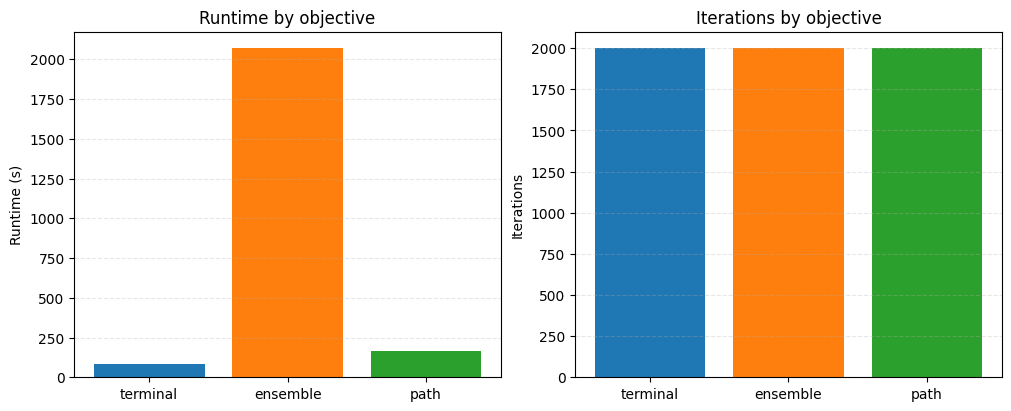

In [10]:
# Runtime and iteration comparison
if not results:
    print('Run the Stage 1 cell to generate results first.')
else:
    objectives = []
    runtimes = []
    iterations = []
    for objective, res in results.items():
        metrics = res.final_metrics
        runtime = float(metrics.get('runtime_s', np.nan))
        hist_total = res.history.get('total')
        iter_count = int(hist_total.size) if hist_total is not None else int(metrics.get('iterations', np.nan))
        objectives.append(objective)
        runtimes.append(runtime)
        iterations.append(iter_count)

    fig_dir = (artifact_root / export_subdir / 'figures').resolve()
    fig_dir.mkdir(parents=True, exist_ok=True)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
    axes[0].bar(objectives, runtimes, color=['C0', 'C1', 'C2'])
    axes[0].set_ylabel('Runtime (s)')
    axes[0].set_title('Runtime by objective')
    axes[0].grid(True, axis='y', linestyle='--', alpha=0.3)

    axes[1].bar(objectives, iterations, color=['C0', 'C1', 'C2'])
    axes[1].set_ylabel('Iterations')
    axes[1].set_title('Iterations by objective')
    axes[1].grid(True, axis='y', linestyle='--', alpha=0.3)

    stem = 'runtime_iterations_by_objective'
    save_figure(fig, fig_dir, stem, save_svg=True)
    print(f"Saved figure: {fig_dir / (stem + '.png')}")
    plt.show()


Saved figure: /home/yehon/projects/grape-crab-qoc/artifacts/objective_comparison/figures/pulse_vs_baseline.png


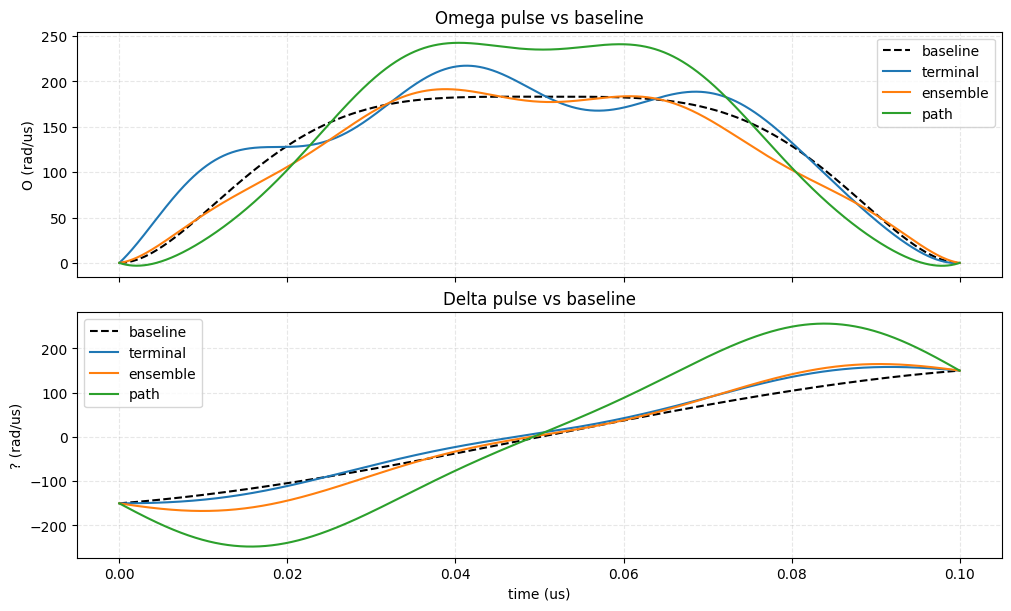

Control minima (rad/us) and negative fractions:
  terminal: min Omega = -0.1595, min Delta = -150.0000, neg frac Omega = 0.009, neg frac Delta = 0.470
  ensemble: min Omega = +0.0000, min Delta = -167.1977, neg frac Omega = 0.000, neg frac Delta = 0.489
  path: min Omega = -3.1898, min Delta = -247.6814, neg frac Omega = 0.088, neg frac Delta = 0.492


In [11]:
# Compare optimized pulses to baseline
if not results:
    print('Run the Stage 1 cell to generate results first.')
else:
    fig_dir = (artifact_root / export_subdir / 'figures').resolve()
    fig_dir.mkdir(parents=True, exist_ok=True)

    # Pull a consistent time grid and baseline from any result
    any_res = next(iter(results.values()))
    pulses_any = any_res.pulses
    t_us = np.asarray(pulses_any.get('t_us'), dtype=np.float64)
    omega_base = np.asarray(pulses_any.get('omega_base'), dtype=np.float64)
    delta_base = pulses_any.get('delta_base')
    delta_base = np.zeros_like(omega_base) if delta_base is None else np.asarray(delta_base, dtype=np.float64)

    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, constrained_layout=True)
    axes[0].plot(t_us, omega_base, 'k--', label='baseline')
    axes[1].plot(t_us, delta_base, 'k--', label='baseline')

    for objective, res in results.items():
        p = res.pulses
        omega = np.asarray(p.get('omega'), dtype=np.float64)
        delta = p.get('delta')
        delta = np.zeros_like(omega) if delta is None else np.asarray(delta, dtype=np.float64)
        axes[0].plot(t_us, omega, label=objective)
        axes[1].plot(t_us, delta, label=objective)

    axes[0].set_ylabel('O (rad/us)')
    axes[0].set_title('Omega pulse vs baseline')
    axes[0].grid(True, linestyle='--', alpha=0.3)
    axes[0].legend()

    axes[1].set_xlabel('time (us)')
    axes[1].set_ylabel('? (rad/us)')
    axes[1].set_title('Delta pulse vs baseline')
    axes[1].grid(True, linestyle='--', alpha=0.3)
    axes[1].legend()

    stem = 'pulse_vs_baseline'
    save_figure(fig, fig_dir, stem, save_svg=True)
    print(f"Saved figure: {fig_dir / (stem + '.png')}")
    plt.show()

OMEGA, DELTA = {}, {}
OMEGA["baseline"] = omega_base
DELTA["baseline"] = delta_base
np.save(f'notebooks/results/GRAPE/OMEGA_baseline.npy', OMEGA["baseline"])
np.save(f'notebooks/results/GRAPE/DELTA_baseline.npy', DELTA["baseline"])
print('Control minima (rad/us) and negative fractions:')
for objective, res in results.items():
    p = res.pulses
    omega = np.asarray(p.get('omega'), dtype=np.float64)
    delta = p.get('delta')
    delta = np.zeros_like(omega) if delta is None else np.asarray(delta, dtype=np.float64)
    neg_frac_omega = float(np.mean(omega < 0.0))
    neg_frac_delta = float(np.mean(delta < 0.0))
    print(f"  {objective}: min Omega = {omega.min():+.4f}, min Delta = {delta.min():+.4f}, neg frac Omega = {neg_frac_omega:.3f}, neg frac Delta = {neg_frac_delta:.3f}")
    OMEGA[objective] = omega
    DELTA[objective] = delta
    # save pulses as .npy in notebooks/results/GRAPE
    np.save(f'notebooks/results/GRAPE/OMEGA_{objective}.npy', OMEGA[objective])
    np.save(f'notebooks/results/GRAPE/DELTA_{objective}.npy', DELTA[objective])






### Cost Components vs Iteration

Saved figure: /home/yehon/projects/grape-crab-qoc/artifacts/objective_comparison/figures/Cost_components_by_iteration.png


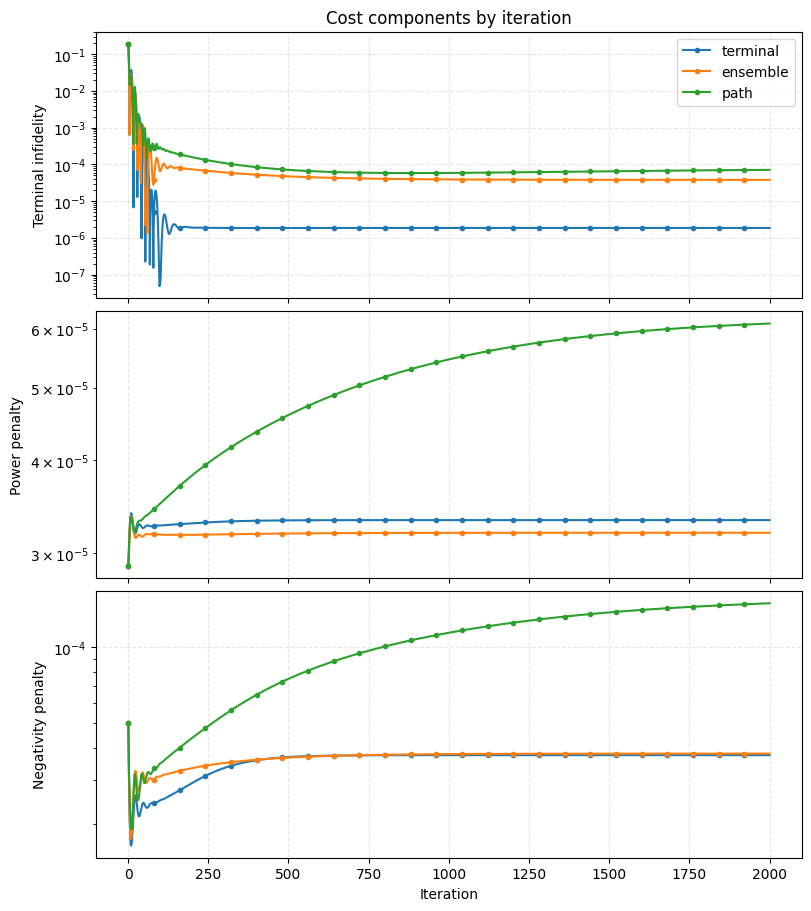

In [12]:
# Plot terminal infidelity, power penalty, and negativity penalty per iteration (log scale)
if not results:
    print('Run the Stage 1 cell to generate results first.')
else:
    metric_keys = {
        'terminal': 'Terminal infidelity',
        'power_penalty': 'Power penalty',
        'neg_penalty': 'Negativity penalty',
    }
    fig, axes = plt.subplots(len(metric_keys), 1, figsize=(8, 9), sharex=True, constrained_layout=True)
    if len(metric_keys) == 1:
        axes = [axes]
    for ax, (key, label) in zip(axes, metric_keys.items()):
        for objective, res in results.items():
            history = res.history
            values = history.get(key)
            if values is None or len(values) == 0:
                continue
            values = np.asarray(values, dtype=np.float64)
            idx = np.arange(1, values.size + 1)
            ax.semilogy(idx, np.maximum(values, 1e-15), label=objective, marker='o', markersize=3, markevery=max(1, values.size // 25))
        ax.set_ylabel(label)
        ax.grid(True, linestyle='--', alpha=0.3)
    axes[-1].set_xlabel('Iteration')
    axes[0].set_title('Cost components by iteration')
    axes[0].legend()
    stem = 'Cost_components_by_iteration'
    save_figure(fig, fig_dir, stem, save_svg=True)
    print(f"Saved figure: {fig_dir / (stem + '.png')}")
    plt.show()


Saved figure: /home/yehon/projects/grape-crab-qoc/artifacts/objective_comparison/figures/total_cost_convergence.png


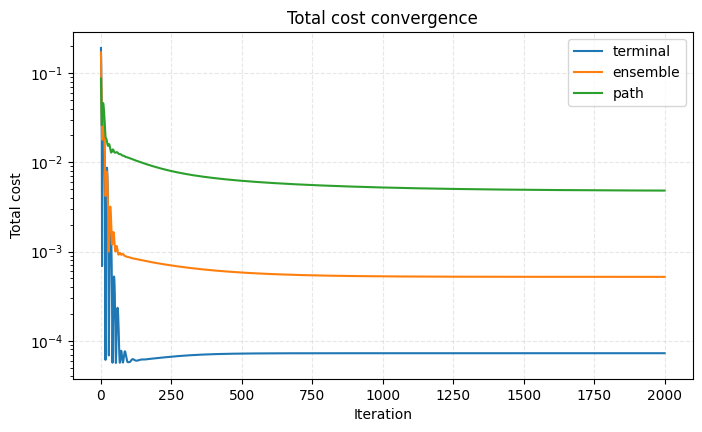

In [13]:
# Total cost vs iteration (log scale)
if not results:
    print('Run the Stage 1 cell to generate results first.')
else:
    fig_dir = (artifact_root / export_subdir / 'figures').resolve()
    fig_dir.mkdir(parents=True, exist_ok=True)

    fig, ax = plt.subplots(figsize=(8, 4.5))
    for objective, res in results.items():
        history_total = res.history.get('total')
        if history_total is None or len(history_total) == 0:
            continue
        values = np.asarray(history_total, dtype=np.float64)
        idx = np.arange(0, values.size)
        ax.semilogy(idx, np.maximum(values, 1e-15), label=objective)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Total cost')
    ax.set_title('Total cost convergence')
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend()

    stem = 'total_cost_convergence'
    save_figure(fig, fig_dir, stem, save_svg=True)
    print(f"Saved figure: {fig_dir / (stem + '.png')}")
    plt.show()


### Baseline Pulse Bloch Dynamics

Saved figure: /home/yehon/projects/grape-crab-qoc/artifacts/objective_comparison/figures/bloch_dynamics.png


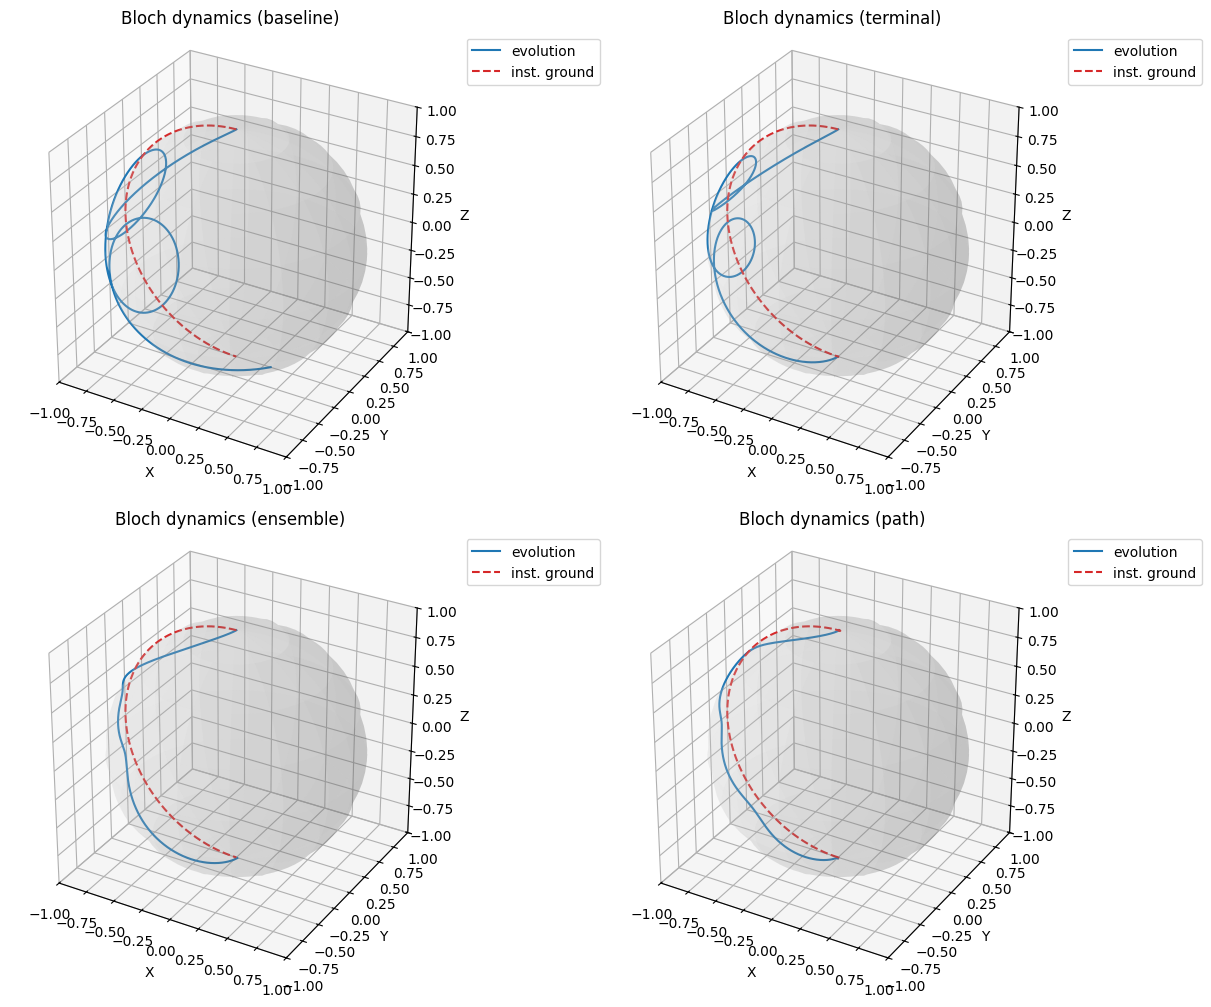

In [14]:
# Bloch-sphere dynamics: baseline and optimized pulses
if not results:
    print('Run the Stage 1 cell to generate results first.')
else:
    fig_dir = (artifact_root / export_subdir / 'figures').resolve()
    fig_dir.mkdir(parents=True, exist_ok=True)

    dt_us = float(runner_ctx.dt_us)

    u = np.linspace(0.0, 2.0 * np.pi, 64)
    v = np.linspace(0.0, np.pi, 32)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones_like(u), np.cos(v))

    entries = []
    arrays = runner_ctx.arrays
    omega_base = np.asarray(arrays.get('Omega0'), dtype=np.float64)
    delta_base = arrays.get('Delta0')
    delta_base = np.zeros_like(omega_base) if delta_base is None else np.asarray(delta_base, dtype=np.float64)
    traj_base = propagate_piecewise_const(omega_base, delta_base, dt_us, psi0=runner_ctx.psi0)
    rho_base = np.asarray(traj_base['rho_path'])
    bloch_base = np.stack([bloch_components(rho_base[k]) for k in range(rho_base.shape[0])], axis=0)
    P_base = ground_state_projectors(omega_base, delta_base)
    bloch_base_gs = np.stack([bloch_components(P_base[k]) for k in range(P_base.shape[0])], axis=0)
    entries.append(('baseline', bloch_base, bloch_base_gs))

    for objective, res in results.items():
        p = res.pulses
        omega = np.asarray(p.get('omega'), dtype=np.float64)
        delta = p.get('delta')
        delta = np.zeros_like(omega) if delta is None else np.asarray(delta, dtype=np.float64)
        traj = propagate_piecewise_const(omega, delta, dt_us, psi0=runner_ctx.psi0)
        rho_path = np.asarray(traj['rho_path'])
        bloch = np.stack([bloch_components(rho_path[k]) for k in range(rho_path.shape[0])], axis=0)
        P_gs = ground_state_projectors(omega, delta)
        bloch_gs = np.stack([bloch_components(P_gs[k]) for k in range(P_gs.shape[0])], axis=0)
        entries.append((objective, bloch, bloch_gs))

    cols = 2
    rows = (len(entries) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows), subplot_kw={'projection': '3d'}, constrained_layout=True)
    axes = np.atleast_1d(axes).reshape(-1)

    for ax in axes[len(entries):]:
        ax.remove()

    for ax, (label, bloch_curve, bloch_gs_curve) in zip(axes, entries):
        ax.plot_surface(xs, ys, zs, rstride=4, cstride=4, color='lightgray', alpha=0.15, linewidth=0)
        ax.plot(bloch_curve[:, 0], bloch_curve[:, 1], bloch_curve[:, 2], label='evolution', color='C0')
        ax.plot(bloch_gs_curve[:, 0], bloch_gs_curve[:, 1], bloch_gs_curve[:, 2], label='inst. ground', color='C3', linestyle='--')
        ax.set_xlim(-1.0, 1.0)
        ax.set_ylim(-1.0, 1.0)
        ax.set_zlim(-1.0, 1.0)
        try:
            ax.set_box_aspect((1, 1, 1))
        except Exception:
            pass
        ax.set_title(f'Bloch dynamics ({label})')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0))

    stem = 'bloch_dynamics'
    save_figure(fig, fig_dir, stem, save_svg=True)
    print(f"Saved figure: {fig_dir / (stem + '.png')}")
    plt.show()


## Stage 3: Robustness Heatmaps

In [15]:
# Heatmap grid parameters
area_pi_values = np.linspace(0.1, 8.0, 40)
detuning_shifts = np.linspace(-140.0, 140.0, 41)

heatmap_data: Dict[str, Dict[str, np.ndarray]] = {}


In [16]:
# Helper to evaluate log10 infidelity over the grid
if not results:
    print('Run the Stage 1 cell to generate results first.')
else:
    psi_target = runner_ctx.target
    dt_us = float(runner_ctx.dt_us)

    heatmap_data.clear()

    arrays = runner_ctx.arrays
    omega_base = np.asarray(arrays.get('Omega0'), dtype=np.float64)
    delta_base = arrays.get('Delta0')
    delta_base = np.zeros_like(omega_base) if delta_base is None else np.asarray(delta_base, dtype=np.float64)
    t_us = np.asarray(arrays.get('t_us'), dtype=np.float64)

    def evaluate_heatmap(label: str, omega_nom: np.ndarray, delta_nom: np.ndarray):
        heat = np.empty((detuning_shifts.size, area_pi_values.size), dtype=np.float64)
        area_ref = float(np.trapezoid(np.abs(omega_nom), t_us) / np.pi)
        if area_ref <= 0.0:
            raise ValueError(f'Pulse area is zero for label {label}.')
        for i_shift, det_shift in enumerate(detuning_shifts):
            delta_shifted = delta_nom + det_shift
            for j_area, area_pi in enumerate(area_pi_values):
                scale = float(area_pi / area_ref)
                omega_scaled = omega_nom * scale
                traj = propagate_piecewise_const(omega_scaled, delta_shifted, dt_us, psi0=runner_ctx.psi0)
                psi_T = traj['psi_T']
                fidelity = fidelity_pure(psi_T, psi_target)
                infidelity = max(1.0 - fidelity, 1e-12)
                heat[i_shift, j_area] = np.log10(infidelity)
        heatmap_data[label] = {
            'log10_infidelity': heat,
            'area_pi_values': area_pi_values.copy(),
            'detuning_shifts': detuning_shifts.copy(),
        }

    evaluate_heatmap('baseline', omega_base, delta_base)

    for objective, res in results.items():
        pulses = res.pulses
        omega_nom = np.asarray(pulses.get('omega'), dtype=np.float64)
        delta_nom_raw = pulses.get('delta')
        delta_nom = np.zeros_like(omega_nom) if delta_nom_raw is None else np.asarray(delta_nom_raw, dtype=np.float64)
        evaluate_heatmap(objective, omega_nom, delta_nom)

    print(f"Computed heatmap grids for labels: {', '.join(heatmap_data.keys())}.")


Computed heatmap grids for labels: baseline, terminal, ensemble, path.


Saved figure: /home/yehon/projects/grape-crab-qoc/artifacts/objective_comparison/figures/robustness_heatmaps.png


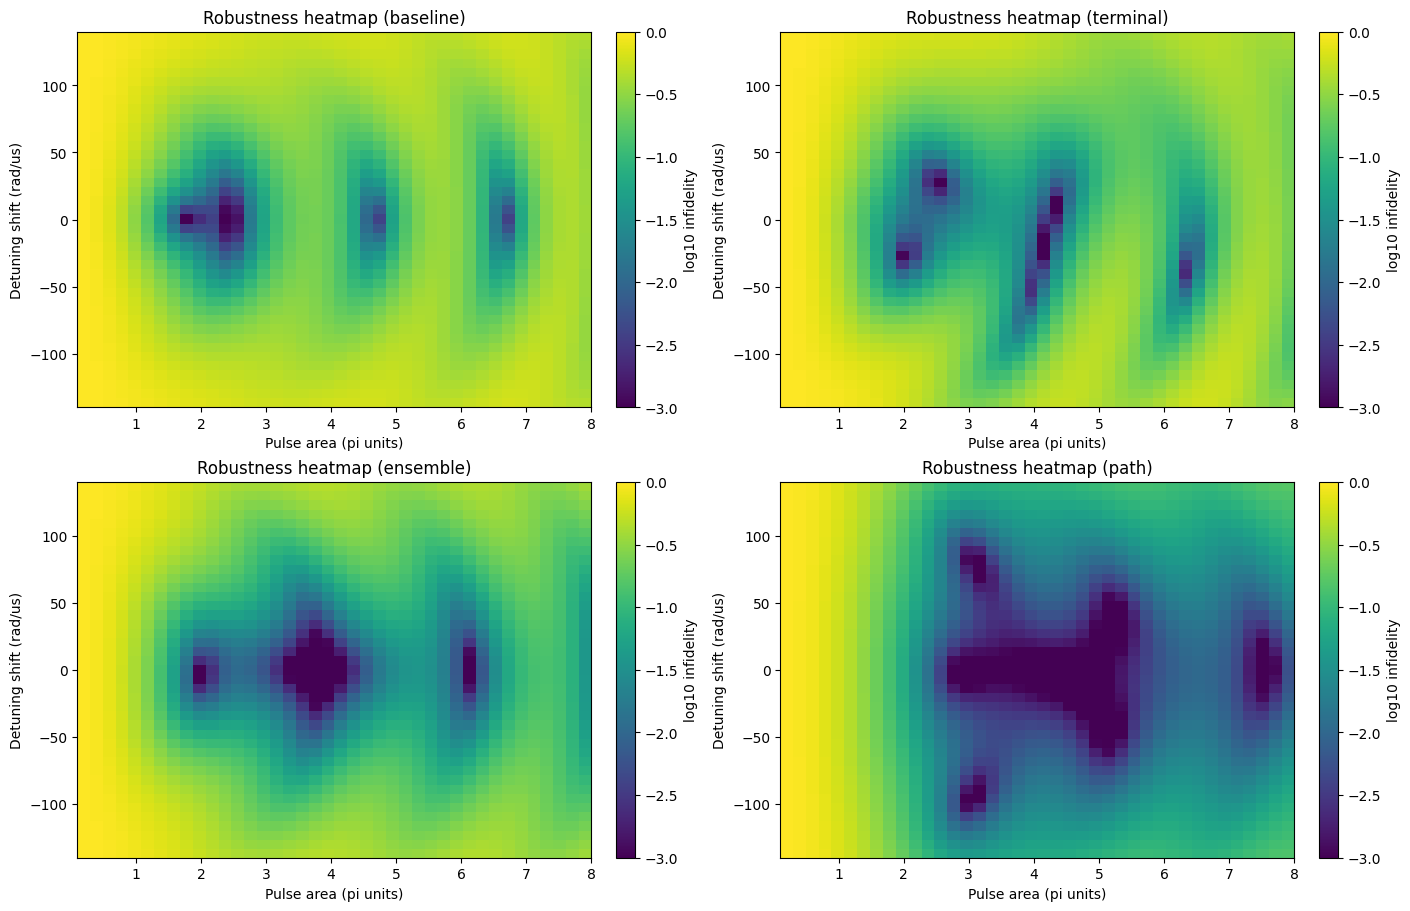

In [17]:
# Plot heatmaps (log10 infidelity)
if not heatmap_data:
    print('Run the heatmap computation cell first.')
else:
    fig_dir = (artifact_root / export_subdir / 'figures').resolve()
    fig_dir.mkdir(parents=True, exist_ok=True)

    labels = list(heatmap_data.keys())
    cols = 2
    rows = (len(labels) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 4.5 * rows), constrained_layout=True)
    axes = np.atleast_1d(axes).reshape(-1)

    for ax in axes[len(labels):]:
        ax.remove()

    for ax, label in zip(axes, labels):
        payload = heatmap_data[label]
        heat = payload['log10_infidelity']
        area_vals = payload['area_pi_values']
        det_vals = payload['detuning_shifts']
        im = ax.imshow(
            heat,
            aspect='auto',
            origin='lower',
            extent=[area_vals[0], area_vals[-1], det_vals[0], det_vals[-1]],
            cmap='viridis',
            vmin=-3.0,
            vmax=0.0,
        )
        ax.set_xlabel('Pulse area (pi units)')
        ax.set_ylabel('Detuning shift (rad/us)')
        ax.set_title(f'Robustness heatmap ({label})')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='log10 infidelity')

    stem = 'robustness_heatmaps'
    save_figure(fig, fig_dir, stem, save_svg=True)
    print(f"Saved figure: {fig_dir / (stem + '.png')}")
    plt.show()
